This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

I've got an annoying warning message from the wrapper and I can't figure out how to get rid of it. If anybody figures this out please send a message to stevecoggeshall@gmail.com

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 300
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1
j = 0

In [3]:
FDR_oot = pd.read_csv('FDR_oot_21.csv')

Max possible savings: 18,828,000.0


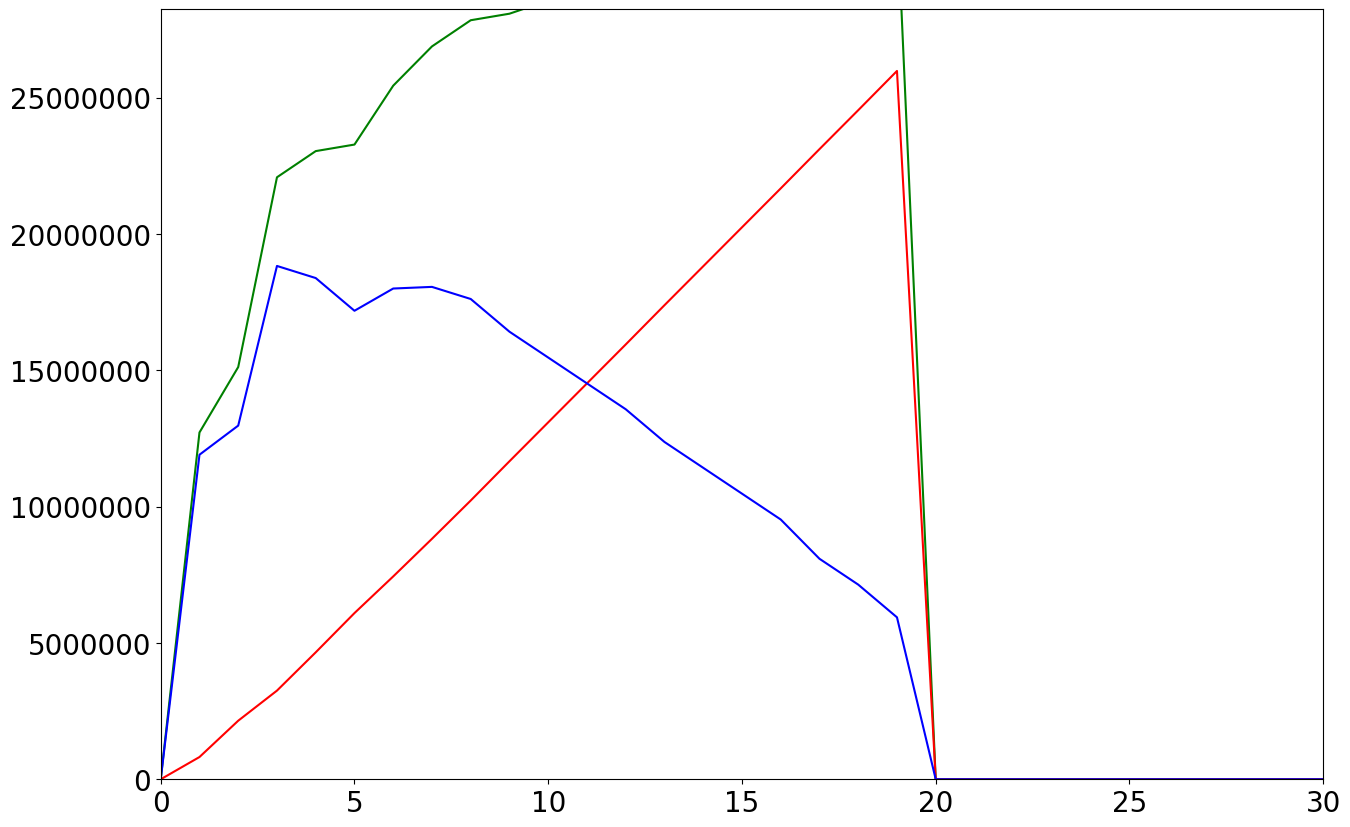

In [5]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(20):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')


In [7]:
Financials_oot

,Fraud Savings,FP Loss,Overall Savings
0,0.0,0.0,0.0
1,12720000.0,816000.0,11904000.0
2,15120000.0,2148000.0,12972000.0
3,22080000.0,3252000.0,18828000.0
4,23040000.0,4656000.0,18384000.0
...,...,...,...
96,0.0,0.0,0.0
97,0.0,0.0,0.0
98,0.0,0.0,0.0
99,0.0,0.0,0.0


## Run a filter on all the files

In [26]:
%%time
filter_score_df_list = []
# for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
file_name = 'candidate_variables.csv'
mylist = []
# df = pd.DataFrame()
# for chunk in pd.read_csv('vars3.csv', on_bad_lines = 'skip', chunksize=10000, low_memory = False):
#     print(j)
#     j += 1
#     df = pd.concat([df, chunk], axis= 0)
df = pd.read_csv('candidate_variables.csv')

del mylist
#     df = pd.read_csv(file_name, on_bad_lines='skip')
print("********** working on",file_name,"size is",df.shape)
df = df.set_index(index_name) 
# df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
# df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
goods = df[df[y_name] == good_label]
bads = df[df[y_name] == bad_label]
del df # don't need this file anymore
num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2
df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)
filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
filter_score.columns = ['variable','filter score']   
j = 0
for column in df_sampled:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1
    if j%100 == 0:
        print(j)

filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
print(file_name,filter_score.head(20))
# if(i == 0): # if first time through need to initialize some stuff
Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
df_top = df_sampled.filter(vars_keep, axis=1)

# if(i > 0): # if more than one variable file we use this loop
    # data_new_top = df_sampled.filter(vars_keep, axis=1)
# df_top = pd.concat([df_top,data_new_top], axis=1)

filter_score_df_list.append(filter_score)

del goods # delete these before starting the next file, if any
del bads
gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (96397, 1424)


<timed exec>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
candidate_variables.csv                        variable  filter score
0                         Fraud      1.000000
421           card_zip3_total_7      0.674106
229            card_zip_total_7      0.664348
430          card_zip3_total_14      0.657958
412           card_zip3_total_3      0.656702
238           card_zip_total_14      0.650481
220            card_zip_total_3      0.648657
247           card_zip_total_30      0.635873
165          card_merch_total_7      0.635546
419             card_zip3_max_7      0.628812
439          card_zip3_total_30      0.628361
174         card_merch_total_14      0.628354
156          card_merch_total_3      0.627462
428            card_zip3_max_14      0.626143
236             card_zip_max_14      0.624522
227              card_zip_max_7      0.623079
245             card_zip_max_30      0.621275
485      Card_Merchdesc_total_7      0.619796
256           card_zip_total_60      0.61

In [27]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [28]:
# cols = df.columns
# df = pd.DataFrame()
# df['cols'] = cols
# df.to_csv('cols.csv')

In [29]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.674106
2,card_zip_total_7,0.664348
3,card_zip3_total_14,0.657958
4,card_zip3_total_3,0.656702
5,card_zip_total_14,0.650481
6,card_zip_total_3,0.648657
7,card_zip_total_30,0.635873
8,card_merch_total_7,0.635546
9,card_zip3_max_7,0.628812


In [30]:
filter_score.tail(10)

,variable,filter score
1414,Card_Merchdesc_unique_count_for_zip3_3,0.000996
1415,card_merch_unique_count_for_zip3_7,0.000954
1416,Card_Merchdesc_unique_count_for_zip3_1,0.000818
1417,card_merch_unique_count_for_zip3_3,0.000818
1418,Card_Merchnum_desc_unique_count_for_zip3_7,0.000808
1419,card_merch_unique_count_for_zip3_1,0.000692
1420,Merchnum_desc_unique_count_for_zip3_3,0.000692
1421,Card_Merchnum_desc_unique_count_for_zip3_3,0.000671
1422,Card_Merchnum_desc_unique_count_for_zip3_1,0.000587
1423,card_merch_unique_count_for_Cardnum_1,0.000000


In [31]:
filter_score.shape

(1424, 2)

In [32]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(0,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_14', 'card_zip3_total_3', 'card_zip_total_14', 'card_zip_total_3', 'card_zip_total_30', 'card_merch_total_7', 'card_zip3_max_7', 'card_zip3_total_30', 'card_merch_total_14', 'card_merch_total_3', 'card_zip3_max_14', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'card_zip_total_60', 'Card_Merchnum_desc_total_7', 'card_merch_total_30', 'Card_Merchdesc_total_14', 'card_zip3_total_1', 'card_zip3_max_30', 'Card_Merchnum_desc_total_14', 'card_zip3_total_60', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'Card_Merchdesc_total_30', 'Card_Merchnum_desc_total_30', 'Card_Merchnum_desc_total_3', 'card_zip3_max_3', 'card_zip_max_60', 'card_merch_max_14', 'card_merch_max_30', 'Card_Merchdesc_max_14', 'card_merch_max_7', 'Card_Merchdesc_max_7', 'Card_Merchdesc_max_30', 'Card_Merchnum_desc_max_14', 'card_merch_total_60', 'Card_Merchnum_desc_max_30', 'card_zip_max_3', 'Card_Merchnum_desc_max_7',

In [33]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip_total_7,card_zip3_total_14,card_zip3_total_3,card_zip_total_14,card_zip_total_3,card_zip_total_30,card_merch_total_7,card_zip3_max_7,card_zip3_total_30,...,Merchnum_total_7,merch_zip_total_3,card_zip3_avg_30,Merchnum_total_1,Cardnum_avg_1,card_merch_avg_3,card_merch_avg_7,merch_zip_total_7,Card_Merchdesc_avg_30,Merchnum_desc_total_1
Recnum,,,,,,,,,,,,,,,,,,,,,
1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
2,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
3,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
4,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,7.24,7.24,3.62,7.24,3.62,3.62,3.62,7.24,3.62,3.62
5,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,3.62,7.24,...,10.86,10.86,3.62,10.86,3.62,3.62,3.62,10.86,3.62,7.24


In [34]:
df_keep.shape

(96397, 100)

In [35]:
Y.head()

,Fraud
Recnum,
1,0
2,0
3,0
4,0
5,0


In [24]:
Y = Y.values
Y_save = Y.copy()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [14]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [15]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:01:01.726672


In [16]:
print(X.shape,Y.shape)

(96397, 300) (96397, 1)


In [17]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [18]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [19]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [20]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    df_sampled:  1.0 GiB
                        df_top: 221.4 MiB
                       df_keep: 221.4 MiB
                             X: 221.4 MiB
                        Y_save: 753.2 KiB
                  filter_score: 126.9 KiB
                  vars_keep_df: 22.3 KiB
                           ___: 11.8 KiB
                           _10: 11.8 KiB
                            _6:  2.6 KiB


## Run a wrapper on the remaining top variables

LGBM Forward Selection

In [26]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

Wall time: 15min 34s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x000001BA0CE58670>)

In [27]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:16:12.076406


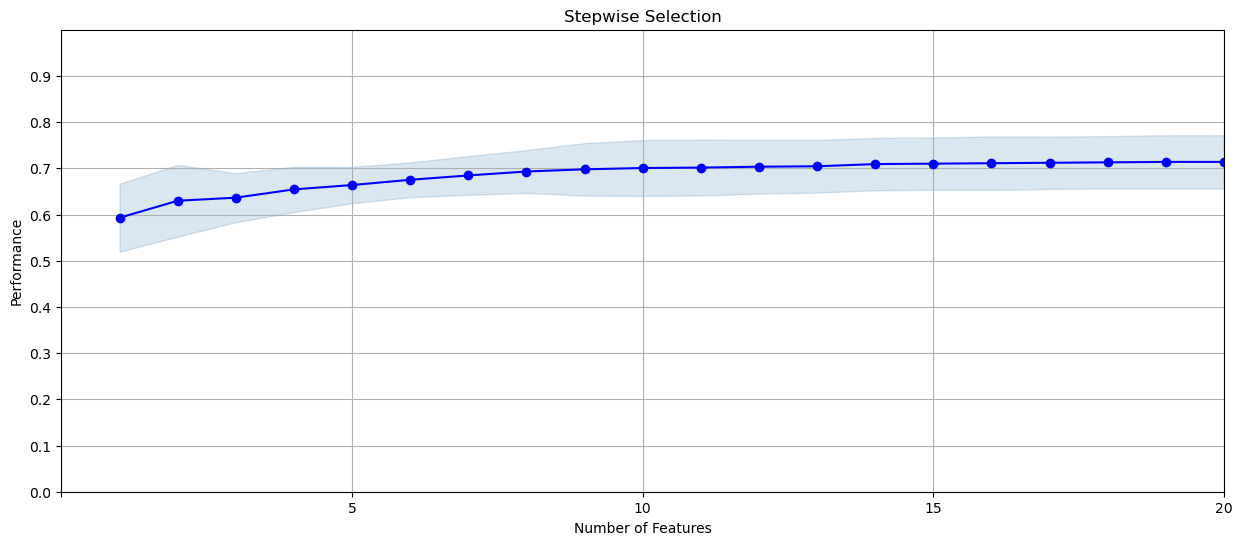

In [28]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [85]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [86]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [87]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(10,)","[0.6968838526912181, 0.546742209631728, 0.5354...",0.593012,"(card_merch_total_14,)",0.16561,0.073594,0.052039,1.0,card_merch_total_14
2,"(10, 48)","[0.7337110481586402, 0.6090651558073654, 0.546...",0.629839,"(card_merch_total_14, Card_Merchnum_desc_max_60)",0.174919,0.07773,0.054964,2.0,[Card_Merchnum_desc_max_60]
3,"(10, 48, 275)","[0.7025495750708215, 0.6345609065155807, 0.572...",0.636449,"(card_merch_total_14, Card_Merchnum_desc_max_6...",0.119754,0.053216,0.03763,3.0,[card_zip3_variability_max_7]
4,"(10, 22, 48, 275)","[0.7223796033994334, 0.6317280453257791, 0.609...",0.654391,"(card_merch_total_14, card_zip3_max_30, Card_M...",0.11017,0.048957,0.034618,4.0,[card_zip3_max_30]
5,"(10, 22, 48, 85, 275)","[0.7195467422096318, 0.6345609065155807, 0.637...",0.663834,"(card_merch_total_14, card_zip3_max_30, Card_M...",0.08869,0.039412,0.027868,5.0,[Cardnum_max_0]
6,"(7, 10, 22, 48, 85, 275)","[0.7252124645892352, 0.6657223796033994, 0.634...",0.675165,"(card_merch_total_7, card_merch_total_14, card...",0.084626,0.037606,0.026591,6.0,[card_merch_total_7]
7,"(7, 10, 22, 48, 85, 275, 297)","[0.7422096317280453, 0.6685552407932012, 0.643...",0.684608,"(card_merch_total_7, card_merch_total_14, card...",0.094602,0.042039,0.029726,7.0,[Merchnum_desc_actual/med_60]
8,"(7, 10, 22, 48, 85, 275, 296, 297)","[0.7507082152974505, 0.6912181303116147, 0.637...",0.693107,"(card_merch_total_7, card_merch_total_14, card...",0.104145,0.04628,0.032725,8.0,[zip3_avg_3]
9,"(7, 10, 22, 48, 85, 103, 275, 296, 297)","[0.7705382436260623, 0.6912181303116147, 0.631...",0.697828,"(card_merch_total_7, card_merch_total_14, card...",0.127957,0.056861,0.040207,9.0,[card_merch_avg_30]
10,"(7, 10, 22, 48, 85, 103, 264, 275, 296, 297)","[0.7790368271954674, 0.6912181303116147, 0.631...",0.700661,"(card_merch_total_7, card_merch_total_14, card...",0.136163,0.060508,0.042786,10.0,[zip3_actual/max_30]


In [88]:
ordered_vars_FS.to_csv('Wrapper_selection_info_FS_300.csv', index=False)

In [89]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list_FS_300.csv',index=False)
vars_keep

1               card_merch_total_14
2       [Card_Merchnum_desc_max_60]
3     [card_zip3_variability_max_7]
4                [card_zip3_max_30]
5                   [Cardnum_max_0]
6              [card_merch_total_7]
7     [Merchnum_desc_actual/med_60]
8                      [zip3_avg_3]
9               [card_merch_avg_30]
10             [zip3_actual/max_30]
11               [card_merch_avg_3]
12          [Merchnum_desc_total_0]
13        [Card_Merchdesc_total_30]
14                [card_zip3_avg_7]
15            [card_merch_total_60]
16         [Merchnum_desc_total_14]
17    [Merchnum_variability_avg_30]
18          [Card_Merchdesc_max_60]
19         [zip3_variability_med_7]
20     [Card_Merchnum_desc_total_7]
Name: variable name, dtype: object

In [90]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

KeyError: "None of ['variable'] are in the columns"

In [91]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.loc[1:, 'variable'] = vars_keep_sorted.loc[1:, 'variable'].apply(lambda x: ' '.join(dict.fromkeys(x).keys()))
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_merch_total_14
Card_Merchnum_desc_max_60
card_zip3_variability_max_7
card_zip3_max_30
Cardnum_max_0


In [92]:
# vars_keep_sorted.loc[0, 'variable'] = vars_keep_sorted.loc[0, 'codes']

In [93]:
vars_keep_sorted

""
variable
card_merch_total_14
Card_Merchnum_desc_max_60
card_zip3_variability_max_7
card_zip3_max_30
Cardnum_max_0
card_merch_total_7
Merchnum_desc_actual/med_60
zip3_avg_3
card_merch_avg_30


In [94]:
# filter_score = filter_score.reset_index()
filter_score

,filter score
variable,
card_zip_total_7,0.664348
card_zip3_total_14,0.657958
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


In [95]:
# vars_keep_sorted.join(filter_score.set_index('variable'), on = 'variable', how = 'left')

In [96]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [97]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted_FS_300.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_merch_total_14,0.628354
1,2,Card_Merchnum_desc_max_60,0.583893
2,3,card_zip3_variability_max_7,0.375468
3,4,card_zip3_max_30,0.612029
4,5,Cardnum_max_0,0.527913
5,6,card_merch_total_7,0.635546
6,7,Merchnum_desc_actual/med_60,0.357341
7,8,zip3_avg_3,0.358089
8,9,card_merch_avg_30,0.520234
9,10,zip3_actual/max_30,0.389127


In [98]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_merch_total_14',
 ['Card_Merchnum_desc_max_60'],
 ['card_zip3_variability_max_7'],
 ['card_zip3_max_30'],
 ['Cardnum_max_0'],
 ['card_merch_total_7'],
 ['Merchnum_desc_actual/med_60'],
 ['zip3_avg_3'],
 ['card_merch_avg_30'],
 ['zip3_actual/max_30'],
 ['card_merch_avg_3'],
 ['Merchnum_desc_total_0'],
 ['Card_Merchdesc_total_30'],
 ['card_zip3_avg_7'],
 ['card_merch_total_60'],
 ['Merchnum_desc_total_14'],
 ['Merchnum_variability_avg_30'],
 ['Card_Merchdesc_max_60'],
 ['zip3_variability_med_7'],
 ['Card_Merchnum_desc_total_7'],
 'Recnum',
 'Fraud']

In [99]:
filter_score

,filter score
variable,
card_zip_total_7,0.664348
card_zip3_total_14,0.657958
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


Random Forest FS

In [100]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
# clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)


Wall time: 1h 37s


SequentialFeatureSelector(cv=3,
                          estimator=RandomForestClassifier(n_estimators=5),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x000001BA0CE58670>)

In [101]:
print('time to here:', dt.datetime.now() - start_time)


time to here: 1:41:57.821336


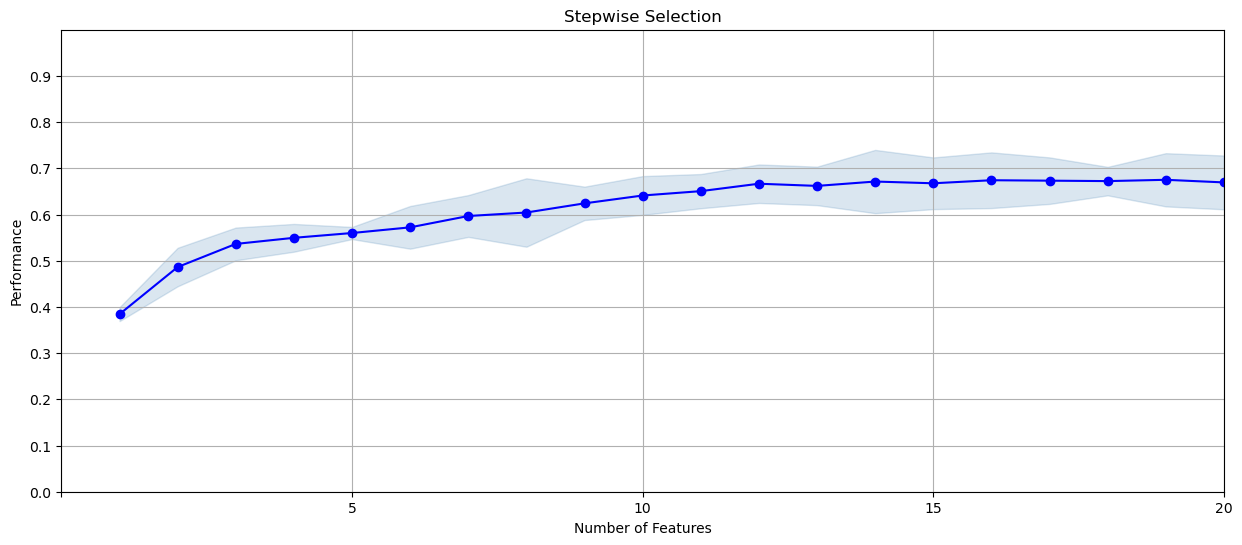

In [102]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()


In [103]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
ordered_vars_FS


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(11,)","[0.40226628895184136, 0.38526912181303113, 0.3...",0.384325,"(card_merch_total_3,)",0.033866,0.015049,0.010642,1.0,card_merch_total_3
2,"(11, 191)","[0.509915014164306, 0.5212464589235127, 0.4277...",0.486308,"(card_merch_total_3, Merchnum_desc_max_7)",0.093739,0.041656,0.029455,2.0,[Merchnum_desc_max_7]
3,"(0, 11, 191)","[0.5694050991501416, 0.5524079320113314, 0.487...",0.536355,"(card_zip3_total_7, card_merch_total_3, Merchn...",0.079679,0.035408,0.025037,3.0,[card_zip3_total_7]
4,"(0, 11, 69, 191)","[0.5722379603399433, 0.5694050991501416, 0.507...",0.549575,"(card_zip3_total_7, card_merch_total_3, Card_M...",0.067666,0.030069,0.021262,4.0,[Card_Merchdesc_total_0]
5,"(0, 11, 67, 69, 191)","[0.5779036827195467, 0.546742209631728, 0.5552...",0.559962,"(card_zip3_total_7, card_merch_total_3, Cardnu...",0.029597,0.013152,0.0093,5.0,[Cardnum_total_1]
6,"(0, 11, 46, 67, 69, 191)","[0.6345609065155807, 0.5580736543909348, 0.524...",0.572238,"(card_zip3_total_7, card_merch_total_3, card_m...",0.103971,0.046203,0.03267,6.0,[card_merch_max_60]
7,"(0, 11, 19, 46, 67, 69, 191)","[0.6543909348441926, 0.5920679886685553, 0.543...",0.596789,"(card_zip3_total_7, card_merch_total_3, card_m...",0.101776,0.045227,0.031981,7.0,[card_merch_total_30]
8,"(0, 11, 19, 46, 67, 69, 127, 191)","[0.6968838526912181, 0.6005665722379604, 0.515...",0.604344,"(card_zip3_total_7, card_merch_total_3, card_m...",0.16667,0.074065,0.052372,8.0,[card_zip3_avg_0]
9,"(0, 11, 19, 46, 67, 69, 127, 181, 191)","[0.6713881019830028, 0.6175637393767706, 0.583...",0.624174,"(card_zip3_total_7, card_merch_total_3, card_m...",0.081361,0.036155,0.025566,9.0,[Cardnum_max_30]
10,"(0, 11, 19, 46, 67, 69, 93, 127, 181, 191)","[0.6883852691218131, 0.6487252124645893, 0.586...",0.641171,"(card_zip3_total_7, card_merch_total_3, card_m...",0.094459,0.041976,0.029681,10.0,[Merchnum_total_1]


In [104]:
ordered_vars_FS.to_csv('Wrapper_selection_info_RF_FS.csv', index=False)
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()


In [105]:
vars_keep.to_csv('final_vars_list_RF_FS_300.csv',index=False)
vars_keep


1             card_merch_total_3
2          [Merchnum_desc_max_7]
3            [card_zip3_total_7]
4       [Card_Merchdesc_total_0]
5              [Cardnum_total_1]
6            [card_merch_max_60]
7          [card_merch_total_30]
8              [card_zip3_avg_0]
9               [Cardnum_max_30]
10            [Merchnum_total_1]
11          [zip3_actual/avg_30]
12       [Merchnum_desc_total_3]
13      [Merchnum_actual/avg_60]
14           [card_zip_total_14]
15        [Card_Merchdesc_max_1]
16           [Merchnum_total_14]
17        [Card_Merchdesc_med_3]
18    [Card_Merchnum_desc_med_7]
19             [Merchnum_avg_30]
20      [Card_Merchdesc_count_7]
Name: variable name, dtype: object

In [106]:
# filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score


,filter score
variable,
card_zip3_total_14,0.657958
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
card_zip_total_30,0.635873
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


In [107]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.loc[1:, 'variable'] = vars_keep_sorted.loc[1:, 'variable'].apply(lambda x: ' '.join(dict.fromkeys(x).keys()))
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()


""
variable
card_merch_total_3
Merchnum_desc_max_7
card_zip3_total_7
Card_Merchdesc_total_0
Cardnum_total_1


In [108]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted_RF_FS_300.csv',index=False)
vars_keep_sorted


,wrapper order,variable,filter score
0,1,card_merch_total_3,0.627462
1,2,Merchnum_desc_max_7,0.481984
2,3,Card_Merchdesc_total_0,0.535956
3,4,Cardnum_total_1,0.538454
4,5,card_merch_max_60,0.589224
5,6,card_merch_total_30,0.614593
6,7,card_zip3_avg_0,0.511950
7,8,Cardnum_max_30,0.487556
8,9,Merchnum_total_1,0.522501
9,10,zip3_actual/avg_30,0.485295


In [109]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list
filter_score

,filter score
variable,
card_zip3_total_14,0.657958
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
card_zip_total_30,0.635873
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


In [110]:
# %%time
# df = pd.read_csv('candidate_variables.csv')
# df.shape

In [111]:
# df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
# print(df_keep.shape)

Catboost

In [112]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = CatBoostClassifier(iterations = 3, depth = 5)
# clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)


Wall time: 25min 21s


SequentialFeatureSelector(cv=3,
                          estimator=<catboost.core.CatBoostClassifier object at 0x000001BA0E184B50>,
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x000001BA0CE58670>)

In [113]:
print('time to here:', dt.datetime.now() - start_time)


time to here: 2:07:21.102450


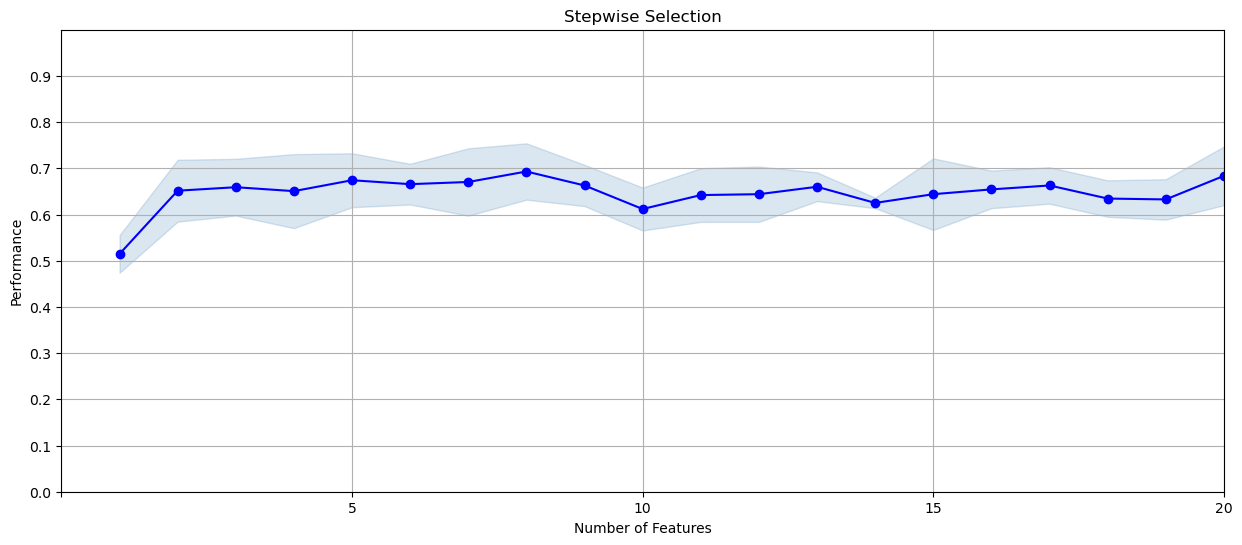

In [114]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()


In [115]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
ordered_vars_FS


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(10,)","[0.5722379603399433, 0.48725212464589235, 0.48...",0.514636,"(card_merch_total_14,)",0.091694,0.040747,0.028812,1.0,card_merch_total_14
2,"(10, 12)","[0.7450424929178471, 0.6175637393767706, 0.592...",0.651558,"(card_merch_total_14, card_zip3_max_14)",0.150587,0.066918,0.047318,2.0,[card_zip3_max_14]
3,"(10, 12, 293)","[0.7308781869688386, 0.6657223796033994, 0.580...",0.659112,"(card_merch_total_14, card_zip3_max_14, zip3_m...",0.138335,0.061473,0.043468,3.0,[zip3_med_1]
4,"(10, 12, 281, 293)","[0.7535410764872521, 0.6402266288951841, 0.558...",0.650614,"(card_merch_total_14, card_zip3_max_14, card_z...",0.180334,0.080137,0.056665,4.0,[card_zip3_count_14]
5,"(10, 12, 99, 281, 293)","[0.7507082152974505, 0.6628895184135978, 0.609...",0.674221,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.13137,0.058378,0.041279,5.0,[Merchnum_desc_total_1]
6,"(10, 12, 58, 99, 281, 293)","[0.71671388101983, 0.6713881019830028, 0.60906...",0.665722,"(card_merch_total_14, card_zip3_max_14, Cardnu...",0.099306,0.04413,0.031204,6.0,[Cardnum_total_7]
7,"(6, 10, 12, 58, 99, 281, 293)","[0.773371104815864, 0.6147308781869688, 0.6232...",0.670444,"(card_zip_total_30, card_merch_total_14, card_...",0.163966,0.072863,0.051522,7.0,[card_zip_total_30]
8,"(6, 10, 12, 58, 99, 223, 281, 293)","[0.7790368271954674, 0.6430594900849859, 0.657...",0.693107,"(card_zip_total_30, card_merch_total_14, card_...",0.137352,0.061036,0.043159,8.0,[zip3_actual/avg_14]
9,"(6, 10, 12, 58, 99, 194, 223, 281, 293)","[0.7110481586402266, 0.6742209631728046, 0.603...",0.66289,"(card_zip_total_30, card_merch_total_14, card_...",0.100526,0.044672,0.031588,9.0,[card_zip3_med_14]
10,"(6, 10, 12, 58, 99, 194, 223, 266, 281, 293)","[0.6515580736543909, 0.6373937677053825, 0.546...",0.611898,"(card_zip_total_30, card_merch_total_14, card_...",0.104491,0.046434,0.032834,10.0,[card_zip3_count_7]


In [116]:
ordered_vars_FS.to_csv('Wrapper_selection_info_CB_FS.csv', index=False)
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list_FS_200.csv',index=False)
vars_keep


1              card_merch_total_14
2               [card_zip3_max_14]
3                     [zip3_med_1]
4             [card_zip3_count_14]
5          [Merchnum_desc_total_1]
6                [Cardnum_total_7]
7              [card_zip_total_30]
8             [zip3_actual/avg_14]
9               [card_zip3_med_14]
10             [card_zip3_count_7]
11         [Card_Merchdesc_max_14]
12             [card_zip_total_14]
13        [Merchnum_actual/avg_60]
14            [card_zip3_total_30]
15    [card_zip_variability_max_7]
16                    [zip3_avg_0]
17              [card_zip_total_3]
18                [Cardnum_med_14]
19             [card_zip3_total_7]
20               [Cardnum_total_1]
Name: variable name, dtype: object

In [117]:
# filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score


,filter score
variable,
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
card_zip_total_30,0.635873
card_merch_total_7,0.635546
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


In [118]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.loc[1:, 'variable'] = vars_keep_sorted.loc[1:, 'variable'].apply(lambda x: ' '.join(dict.fromkeys(x).keys()))
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()


""
variable
card_merch_total_14
card_zip3_max_14
zip3_med_1
card_zip3_count_14
Merchnum_desc_total_1


In [119]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted_CB_FS.csv',index=False)
vars_keep_sorted


,wrapper order,variable,filter score
0,1,card_merch_total_14,0.628354
1,2,card_zip3_max_14,0.626143
2,3,zip3_med_1,0.358885
3,4,card_zip3_count_14,0.370109
4,5,Merchnum_desc_total_1,0.521587
5,6,Cardnum_total_7,0.562048
6,7,card_zip_total_30,0.635873
7,8,zip3_actual/avg_14,0.443510
8,9,card_zip3_med_14,0.478113
9,10,card_zip3_count_7,0.387373


In [120]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list
filter_score

,filter score
variable,
card_zip3_total_3,0.656702
card_zip_total_14,0.650481
card_zip_total_3,0.648657
card_zip_total_30,0.635873
card_merch_total_7,0.635546
...,...
card_merch_unique_count_for_zip3_1,0.000692
Merchnum_desc_unique_count_for_zip3_3,0.000692
Card_Merchnum_desc_unique_count_for_zip3_3,0.000671


In [121]:
# df_keep.to_csv('vars_final_FS.csv',index=False)

In [122]:
# print("duration: ", dt.datetime.now() - start_time)

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)


In [36]:
# cols = df.columns
# df = pd.DataFrame()
# df['cols'] = cols
# df.to_csv('cols.csv')
filter_score.head(30)
filter_score.tail(10)
filter_score.shape
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(0,' vars_keep:',vars_keep)
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()
df_keep.shape
Y.head()


0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_14', 'card_zip3_total_3', 'card_zip_total_14', 'card_zip_total_3', 'card_zip_total_30', 'card_merch_total_7', 'card_zip3_max_7', 'card_zip3_total_30', 'card_merch_total_14', 'card_merch_total_3', 'card_zip3_max_14', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'card_zip_total_60', 'Card_Merchnum_desc_total_7', 'card_merch_total_30', 'Card_Merchdesc_total_14', 'card_zip3_total_1', 'card_zip3_max_30', 'Card_Merchnum_desc_total_14', 'card_zip3_total_60', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'Card_Merchdesc_total_30', 'Card_Merchnum_desc_total_30', 'Card_Merchnum_desc_total_3', 'card_zip3_max_3', 'card_zip_max_60', 'card_merch_max_14', 'card_merch_max_30', 'Card_Merchdesc_max_14', 'card_merch_max_7', 'Card_Merchdesc_max_7', 'Card_Merchdesc_max_30', 'Card_Merchnum_desc_max_14', 'card_merch_total_60', 'Card_Merchnum_desc_max_30', 'card_zip_max_3', 'Card_Merchnum_desc_max_7',

,Fraud
Recnum,
1,0
2,0
3,0
4,0
5,0


In [39]:
# Y = Y.values
Y_save = Y.copy()
# Y = np.array(Y)
X = df_keep
print(Y)
print('time to here:', dt.datetime.now() - start_time)
print(X.shape,Y.shape)
print(type(X),type(Y))
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   


[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
time to here: 0:11:00.968670
(96397, 100) (96397, 1)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [40]:

import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    df_sampled:  1.0 GiB
                        df_top: 74.3 MiB
                       df_keep: 74.3 MiB
                             X: 74.3 MiB
                        Y_save: 753.2 KiB
                  filter_score: 126.9 KiB
                  vars_keep_df:  7.6 KiB
                           _14:  4.0 KiB
                           _21:  4.0 KiB
                           _33:  4.0 KiB


In [41]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
# sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y) 


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Wall time: 41min 3s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          forward=False, k_features=(1, 1), n_jobs=-1,
                          scoring=<function fdr at 0x0000021B73933DC0>)

In [42]:
print('time to here:', dt.datetime.now() - start_time)


time to here: 0:52:21.148398


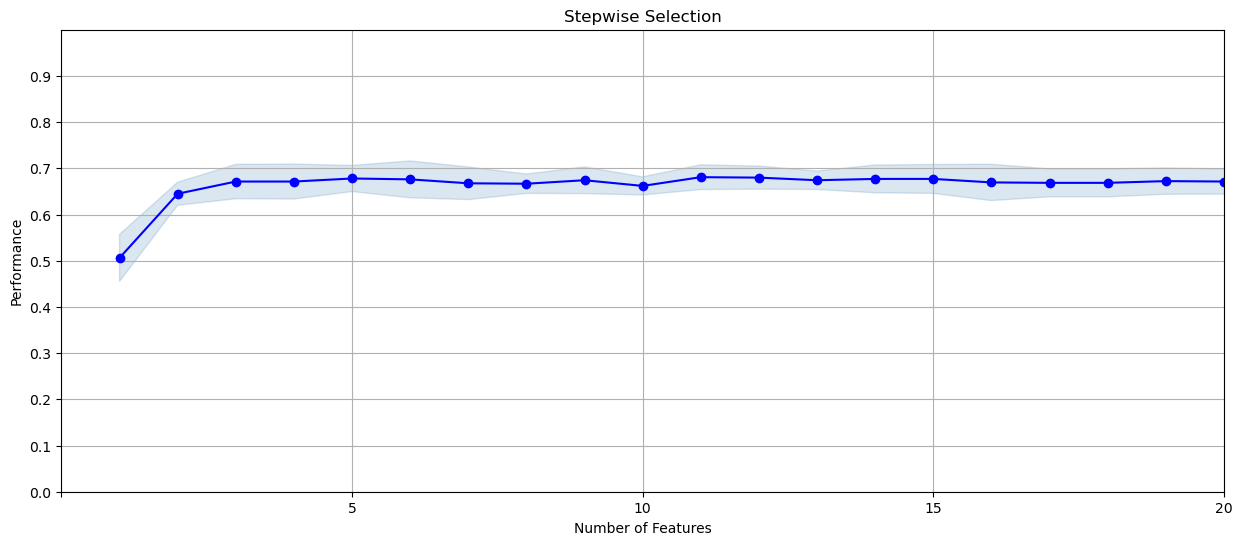

In [43]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars_Backward_selection.png')
plt.show()


In [44]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
ordered_vars_FS


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
100,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6260623229461756, 0.6373937677053825, 0.617...",0.627007,"(card_zip3_total_7, card_zip_total_7, card_zip...",0.01828,0.008123,0.005744,100.0,[card_zip_total_1]
99,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7053824362606232, 0.6373937677053825, 0.617...",0.653447,"(card_zip3_total_7, card_zip_total_7, card_zip...",0.084626,0.037606,0.026591,99.0,[card_zip3_avg_30]
98,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7053824362606232, 0.660056657223796, 0.6175...",0.661001,"(card_zip3_total_7, card_zip_total_7, card_zip...",0.080692,0.035858,0.025355,98.0,[Card_Merchdesc_total_14]
97,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7053824362606232, 0.6543909348441926, 0.626...",0.661945,"(card_zip3_total_7, card_zip_total_7, card_zip...",0.073856,0.03282,0.023207,97.0,[card_zip_avg_30]
96,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7053824362606232, 0.6572237960339944, 0.626...",0.66289,"(card_zip3_total_7, card_zip_total_7, card_zip...",0.073426,0.032629,0.023072,96.0,[Merchnum_desc_total_1]
...,...,...,...,...,...,...,...,...,...
5,"(0, 3, 49, 86, 93)","[0.7082152974504249, 0.6855524079320113, 0.640...",0.677998,"(card_zip3_total_7, card_zip3_total_3, card_zi...",0.063607,0.028266,0.019987,5.0,[Merchnum_total_1]
4,"(0, 3, 49, 86)","[0.7110481586402266, 0.6827195467422096, 0.620...",0.671388,"(card_zip3_total_7, card_zip3_total_3, card_zi...",0.085211,0.037866,0.026775,4.0,[Cardnum_max_1]
3,"(0, 3, 49)","[0.7082152974504249, 0.6855524079320113, 0.620...",0.671388,"(card_zip3_total_7, card_zip3_total_3, card_zi...",0.083768,0.037225,0.026322,3.0,[card_zip3_total_3]
2,"(0, 49)","[0.6798866855524079, 0.6317280453257791, 0.623...",0.644948,"(card_zip3_total_7, card_zip3_max_60)",0.056141,0.024948,0.017641,2.0,[card_zip3_max_60]


In [45]:
ordered_vars_FS.to_csv('Wrapper_selection_info_BS.csv', index=False)
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list_BS_200.csv',index=False)
vars_keep


100           [card_zip_total_1]
99            [card_zip3_avg_30]
98     [Card_Merchdesc_total_14]
97             [card_zip_avg_30]
96       [Merchnum_desc_total_1]
                 ...            
5             [Merchnum_total_1]
4                [Cardnum_max_1]
3            [card_zip3_total_3]
2             [card_zip3_max_60]
1              card_zip3_total_7
Name: variable name, Length: 100, dtype: object

In [46]:
# filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score


,variable,filter score
1,card_zip3_total_7,0.674106
2,card_zip_total_7,0.664348
3,card_zip3_total_14,0.657958
4,card_zip3_total_3,0.656702
5,card_zip_total_14,0.650481
...,...,...
1419,card_merch_unique_count_for_zip3_1,0.000692
1420,Merchnum_desc_unique_count_for_zip3_3,0.000692
1421,Card_Merchnum_desc_unique_count_for_zip3_3,0.000671
1422,Card_Merchnum_desc_unique_count_for_zip3_1,0.000587


In [48]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
# vars_keep_sorted.loc[1:, 'variable'] = vars_keep_sorted.loc[1:, 'variable'].apply(lambda x: ' '.join(dict.fromkeys(x).keys()))
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()


ValueError: Length mismatch: Expected axis has 17 elements, new values have 1 elements

In [ ]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted_BS.csv',index=False)
vars_keep_sorted


In [ ]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list
filter_score